In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected = True) # make the graph show in the notebook
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
import gzip

In [2]:
with gzip.open('calendar.csv.gz', 'rt') as f:
    calendar = pd.read_csv(f)
print('There are', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'different listings')
print('The start date of this dataset is', calendar.date.min(),'and the end date is' ,calendar.date.max())

calendar.head()

There are 365 days and 5223 different listings
The start date of this dataset is 2024-12-30 and the end date is 2025-12-29


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,164448,2024-12-30,t,$950.00,NaN,2,120
1,164448,2024-12-31,f,$950.00,NaN,2,120
2,164448,2025-01-01,f,$950.00,NaN,2,120
3,164448,2025-01-02,f,$950.00,NaN,2,120
4,164448,2025-01-03,t,$950.00,NaN,2,120


Let's start with the overall availability of listings in Stockholm as of the day of this analysis (2025-04-01).
Note that Figure 1 only illustrates to what extent the listings are booked at the time of analysis, which means the results can look very different if conducting a similar analysis later in 2025.

In [5]:
df_ratios = calendar.available.value_counts(normalize = True)
df_ratios = df_ratios.reset_index()
df_ratios['status'] = df_ratios['available'].apply(lambda x: 'Reserved' if x == 'f' else 'Available')

fig1 = px.bar(df_ratios, x = 'status', y = 'proportion', 
              title= 'Figure 1: Overall  Availability of Listings in Stockholm in 2025',
              labels = {'status': 'Status', 'proportion': ' ' },
              range_y = [0, .7])
fig1.update_layout(yaxis_tickformat= ".0%")
py.iplot(fig1)
# fig1.show()

Text(0, 0.5, 'Ratio of Booked Listings')

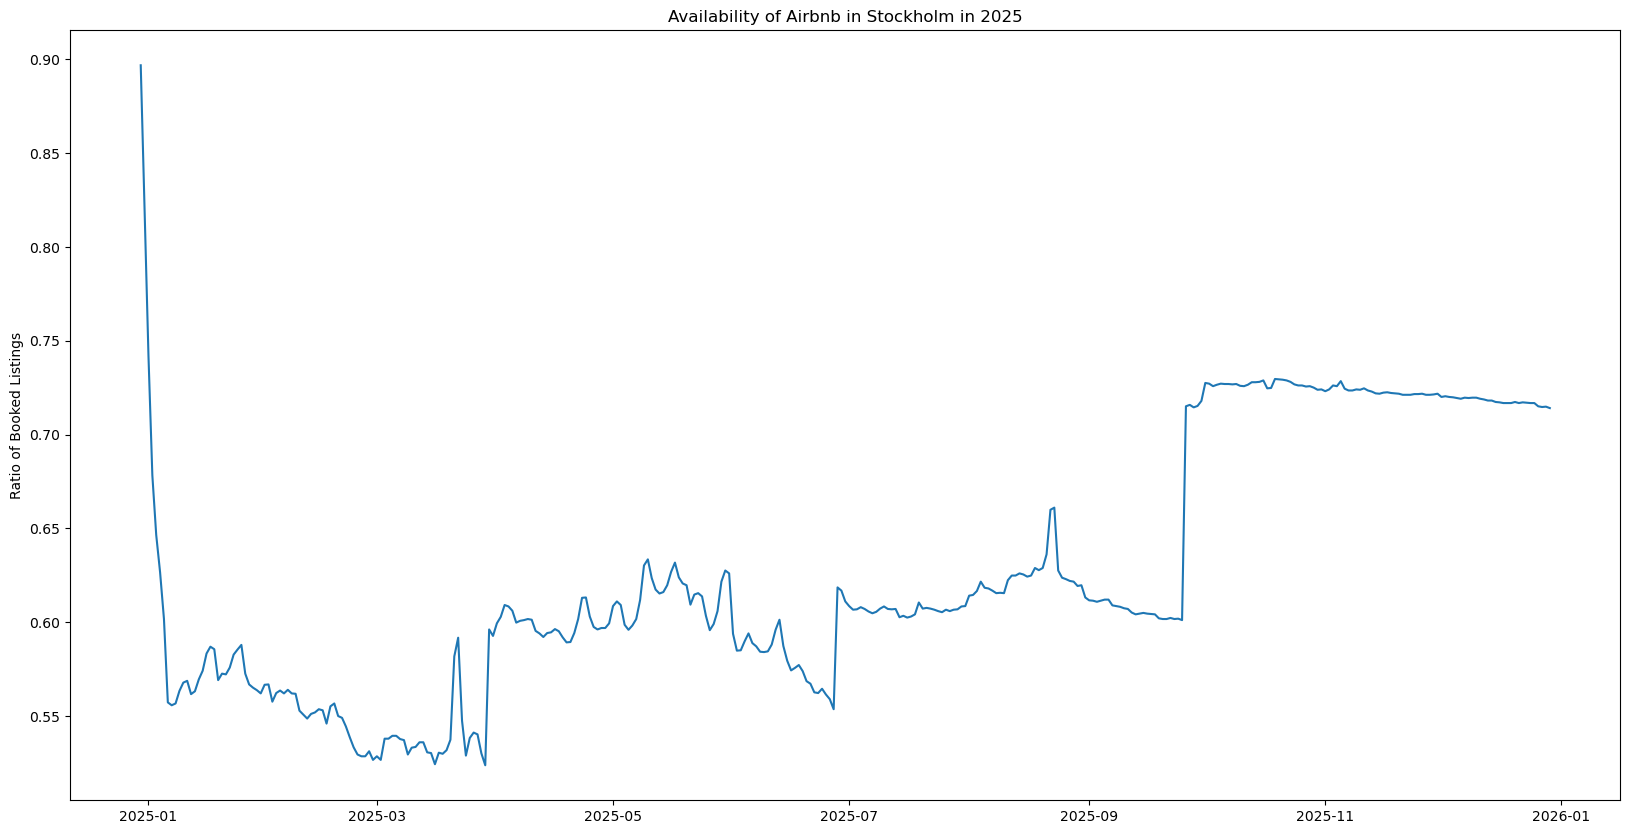

In [5]:
# add a new column called 'busy'
# if a listing is not available, it takes on value 1 otherwise 0
new_calendar = calendar[['date', 'available']]
new_calendar['busy'] = new_calendar.available.map(lambda x:0 if x == 't' else 1)
new_calendar = new_calendar.groupby('date')['busy'].mean().reset_index()
new_calendar['date'] = pd.to_datetime(new_calendar['date'])

plt.figure(figsize= (20, 10))
plt.plot(new_calendar['date'], new_calendar['busy'])
plt.title('Availability of Airbnb in Stockholm in 2025')
plt.ylabel('Ratio of Booked Listings')

Text(0, 0.5, 'Month')

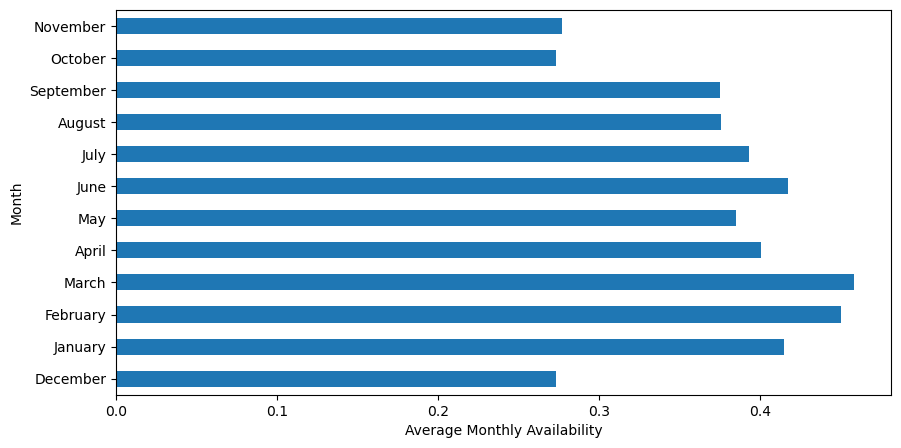

In [6]:
import datetime as dt
calendar['date'] = pd.to_datetime(calendar['date'])
# calendar['price'] = calendar['price'].str.replace('$', '').str.replace(',', '').astype(float)
calendar['booked'] = calendar.available.map(lambda x:1 if x == 't' else 0)
mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B'), sort = False)['booked'].mean()
mean_of_month.plot(kind = 'barh', figsize= (10, 5))
plt.xlabel('Average Monthly Availability')
plt.ylabel('Month')

Higher values suggest that higher number of available listings. From the graph it is clear

In [7]:
calendar['dayofweek'] = calendar.date.dt.day_name()
days = calendar['dayofweek'].unique().tolist()
df_week = price_week = calendar.groupby('dayofweek')['booked'].mean().reindex(days)
df_week = df_week.reset_index()
fig3 = px.line(df_week, x = 'dayofweek', y = 'booked', title= 'Figure 3: Average Availability by Day of Week in Stockholm in 2025', 
               labels = {'dayofweek': '', 'booked': 'Ratio of Available Listings'})
fig3.update_xaxes(tickangle= 45)
fig3.show()
# fig3 = px.line(, x = '')
# price_week.plot(title = 'Availability by Day of Week')
# plt.show()

In [8]:
# listing data
listings = pd.read_csv('./listings.csv')
print('There are a total of', listings.id.nunique(), 'listings in Stockholm as of 2025.')
# listings.info()
# listings.head()
# listings.neighbourhood.unique()

There are a total of 5223 listings in Stockholm as of 2025.


In [9]:
by_area = listings.groupby('neighbourhood').count()[['id']].sort_values('id', ascending= True)
by_area = by_area.reset_index()
fig4 = px.bar(by_area, x = 'neighbourhood', y = 'id', title= 'Number of Listings in Stockholm in 2025 by Area',
              labels = {'neighbourhood': 'Area', 'id': 'Counts'})
fig4.show()

The minimum price per night is \$ 105 and the maximum price per night is up to \$ 500000, which makes the initial visualization not very comprehensible. Thus, I removed some outliers whose price per night is greater than $ 10000, and this lead to a removal of 25 listings, which accounts for less than 1% of the listings in Stockholm.

As what is shown in *Figure 5*, the median price per night in each area does not differ much but some areas, such as Sodermalms and Norrmalms see a considerable number of listings whose price is much higher than the average. 

In [10]:
# distribution of price per night 
# min = 105 max = 500000
# remove outliers

listings_cleaned = listings[listings.price < 10000]
area_order = by_area['neighbourhood'].tolist()
area_order
fig5 = px.box(listings_cleaned, x = 'neighbourhood', y ='price', 
              title = 'Figure 5: Price of Arbnb Listing Per Night in Stockholm in 2025 by Area',
              labels = {'neighbourhood': 'Area', 'price': 'Price'},
              category_orders = {'neighbourhood': area_order})
fig5.show()


In [62]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
listings.price[listings['room_type'] == 'Private room'].max()

# main graph
fig_price_by_type = make_subplots(rows = 2, cols = 2)
# eliciting data
d_pv_room = listings_cleaned['price'][listings_cleaned.room_type == 'Private room']
d_entire = listings_cleaned['price'][listings_cleaned.room_type == 'Entire home/apt']
d_share = listings_cleaned['price'][listings_cleaned.room_type == 'Shared room']
d_hotel = listings_cleaned['price'][listings_cleaned.room_type == 'Hotel room']
# unify xlim
max_price_pv_entire = max(d_pv_room.max(), d_entire.max())
max_price_share_hotel = max(d_share.max(), d_hotel.max()) *1.1
# histogram
pv_room = go.Histogram(x = d_pv_room, name = 'Private Room', xbins = dict(size=100, end= max_price_pv_entire))
entire = go.Histogram(x = d_entire, name = 'Entire Home/Apt' ,xbins= dict(size=100, end= max_price_pv_entire))
share = go.Histogram(x = d_share, name = 'Share Room', xbins= dict(size = 100, end = max_price_share_hotel))
hotel = go.Histogram(x = d_hotel, name = 'Hotel Room', xbins= dict(end = max_price_share_hotel))
# append sub plots
fig_price_by_type.append_trace(pv_room, 1 ,1)
fig_price_by_type.append_trace(entire, 1, 2)
fig_price_by_type.append_trace(share, 2, 1)
fig_price_by_type.append_trace(hotel, 2, 2)
# update xlim
fig_price_by_type.update_xaxes(range=[0, max_price_pv_entire], row= 1, col= 1)
fig_price_by_type.update_xaxes(range=[0, max_price_pv_entire], row= 1, col= 2)
fig_price_by_type.update_xaxes(range=[0, max_price_share_hotel], row= 2, col= 1)
fig_price_by_type.update_xaxes(range=[0, max_price_share_hotel], row= 2, col= 2)
# adjust overall layout
fig_price_by_type.update_layout(height=600, width=800, 
                                title_text= 'Arbnb Price Distribution by Room Type in Stockholm in 2025')
fig_price_by_type.show()

# fig6 = px.histogram(listings_cleaned, x = 'price', color = 'room_type', opacity=0.5)
# fig6.add_trace(opacity=0.5)
# fig6.show()

In [48]:
listings_cleaned.room_type.value_counts()
# max_price = max(d_pv_room.max(), d_entire.max())
# max_price

room_type
Entire home/apt    2878
Private room        577
Shared room           7
Hotel room            7
Name: count, dtype: int64

In [79]:
with gzip.open('listings.csv.gz') as file:
    listings_complete = pd.read_csv(file)
# listings_complete.columns.values

In [81]:
listings_complete['amenities'] = listings_complete.amenities.str.replace('[{}]', '').str.replace('"','')
type(listings_complete.amenities[0])

str